# Investigating Language Model Bias in Whisper (small) ASR Model

Reeka Estacio

LIGN 214: Computational Phonetics


## Introduction

OpenAI's automatic speech recognition (ASR) model, Whisper, leverages both a speech-to-text ASR system and a Transformer-based language model to enhance transcription accuracy. While the ASR component learns acoustic information and converts raw speech into text, the integrated language model helps resolve ambiguity and improve fluency [(Radford et al., 2023)](https://proceedings.mlr.press/v202/radford23a.html). This complex architecture achieves high transcription accuracy, but it raises an important question: to what extent does Whisper rely on its language model over its ASR component?

To investigate this question, I intend to measure perplexity in Whisper (small) and compare it to the perplexity obtained from GPT-2, a pure language model, given the same linguistic input. Perplexity quantifies a language model's overall uncertainty when generating predictions. In pure language models (like GPT-2), perplexity is lower for expected words because they are very predictable given highly constrained sentence contexts. Prior research has also shown that semantic relatedness plays a role in decreasing perplexity [(Meng et al., 2021)](arXiv:2110.08743). Unexpected or less predictable words, on the other hand, are assigned higher perplexity. 

Measuring perplexity sufficiently allows us to assess how strongly the Whisper model biases predictability judgements over purely acoustic analysis. If Whisper systematically assigns lower perlexity for statistically probable words and higher perplexity for unexpected words, this would suggest that Whisper exihibts a bias towards its language model component in its predictions, potentially overriding the work of the ASR component that processes the acoustic features of the speech signal.


### The current study 

I aim to measure perplexity computed from Whisper (small) across five different auditory conditions, manipulating both phonological and semantic relationships between words. The conditions are:

1. **`Expected`:** The final word is highly predictable based on prior context.

2. **`Phonologically Related`:** The final word sounds similar to the expected word, but is not predictable given prior context.

3. **`Semantically Related`:** The final word is semantically-related to the expected word but is less predictable given prior context. It does not sound similar to the expected word.

4. **`Both` (phonologically- and semantically-related):** The final word is semantically-related to the expected word but is less predictable given prior context. It also sounds similar to the expected word.

5. **`Neither`:** The final word is neither phonologically similar nor semantically expected, making it highly improbable.

Below is an example set of stimuli:

1. The farmer milked the **cow**. (expected, most probable)

2. The farmer milked the **couch**. (phonologically-related)

3. The farmer milked the **goat**. (semantically-related)

4. The farmer milked the **calf**. (phonologically- and semantically-related)

5. The farmer milked the **rock**. (neither, improbable)


To assess the extent to which Whisper's language model component influences its transcription, I will use GPT-2 perplexity as a pure language model baseline for comparison. I chose to use GPT-2 because it is likely similar to Whisper's embedded language model without its ASR component, while also preserving computational simplicity. If Whisper indeed exhibits a bias towards its language model over its ASR component, perplexity rankings across conditions should pattern similarly to GPT-2, such that highly predictable words are favored over similar-sounding words. This should result in lower perplexity for semantically-related completions, regardless of the acoustic information of the input. Phonologically-related completions (words that sound similar to the expected endings) should result in higher perplexity.

## Methods

### Stimuli

The sentences were generated using ChatGPT 4o. I prompted the language model to generate multiple sets of sentences where the sentence frame stays the same, but the final word varies based on a provided description of the five experimental conditions. In my prompt, I also ensured that the sentence contexts are highly constrained to the expected word. The final set of stimuli consists of 8 sets of five sentences (one sentence corresponding to each condition), resulting in a total of 40 sentences.

While I concede that this is an unconventional approach, the choice to use ChatGPT to generate the experimental stimuli was intentional to maintain the simplicity of the analysis. Given the absence of pre-existing normed stimuli, it is likely that these sentences would reflect biases regardless--either by the model or by my own subjective biases. Since the current analysis is purely an exploratory exercise, I prioritized methodological simplicity over precision in data curation.

To generate the speech input, the sentences were fed into the [ElevenLabs](elevenlabs.io) text-to-speech voice generator. This method was chosen in lieu of collecting speech recordings because it standardizes the speaker and minimizes outside noise that could potentially confound Whisper's transcriptions. The stimuli were generated using the Eleven Multiligual v2 model using the "Rachel" voice. Speaker speed was fixed at 1x speed. Stability, similarity, and style exaggeration were fixed at 50%. The generated audio files were then downloaded as .mp3 files.

The full set of stimuli, including the sentence transcripts and audio files, can be located in the `data` folder on [GitHub](https://github.com/rdestaci/Whisper_LLM_Bias/tree/14f636478534dab9ac30b36e56917b0916cd841f/data).

### Computing perplexity

To begin computing perplexity for each sentence in the stimuli set, I first loaded all necessary libraries and models (GPT-2 and Whisper (small)).

I then processed the stimuli, which includes:

- **`stimuli.csv`:** a file containing the true transcriptions of all sentences and their labeled conditions.
- **path to the `auditory_stimuli` folder:** folder containing the speech input as .mp3 files.

In [3]:
%%capture
# Install necessary libraries
import os
import torch
import whisper
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
%%capture
# Load Whisper model (small)
model = whisper.load_model("small")

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

# Load stimuli and path to folder containing audio files
df_stimuli = pd.read_csv("data/stimuli.csv")
df_stimuli["condition_name"] = df_stimuli["condition_name"].apply(lambda x: x.title())   # rename condition for better readability later
stimuli_folder = os.path.join(os.getcwd(), "data/auditory_stimuli")

Since there is no direct, identical method for computing perplexity for both GPT-2 and Whisper, I defined two functions to compute perplexity:

- `compute_gpt2_perplexity`: Computes GPT-2 perplexity by running a forward pass on the input sentence and taking the exponentiation of the cross-entropy loss.

- `compute_whisper_perplexity`: Transcribes the audio file and extracts the average log probabilities for each segment that Whisper predicts. It *estimates* perplexity by exponentiating the negative mean log probability.

Although these calculations are slightly different, they are equivalent in the sense that they both measure average uncertainty across all tokens/segments. Crucially, it maintains the negative relationship between the perplexity and uncertainty (high perplexity = more uncertainty). 

In [6]:
## Define function for computing GPT-2 perplexity
def compute_gpt2_perplexity(sentence):
    """
    Compute perplexity of given sentence (text) using GPT-2.
    """
    tokens = tokenizer(sentence, return_tensors="pt")   # tokenize sentence
    input_ids = tokens.input_ids
    
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)   # get model outputs
        loss = outputs.loss   # extract cross-entropy loss
        perplexity = torch.exp(loss).item()   # exponentiate loss to compute perplexity
        
    return perplexity

## Define function for computing Whisper perplexity
def compute_whisper_perplexity(audio_filename, model):
    """
    Computes Whisper's perplexity based on average log probability of transcription.
    """
    # Transcribe audio
    result = model.transcribe(audio_filename)
    transcribed_text = result["text"]

    # Extract log probabilities from Whisper
    log_probs = []
    if "segments" in result:
        for segment in result["segments"]:
            if "avg_logprob" in segment:   # Whisper provides segment-level average log probability
                log_probs.append(segment["avg_logprob"])

    # Estimate perplexity
    whisper_perplexity = torch.exp(-torch.tensor(log_probs).mean()).item()

    return transcribed_text, whisper_perplexity

The following code block goes through each audio file, transcribes then with Whisper (small), then calculates both Whisper and GPT-2 perplexity. The resulting DataFrame is then saved to the variable `results`. The first sentence set, including its Whisper transcription and perplexity scores, is displayed below.

In [7]:
# Suppress CPU-related warnings
warnings.simplefilter("ignore")

for index, row in df_stimuli.iterrows():
    audio_filename = os.path.join(stimuli_folder, f"{row['id']}{row['condition_id']}.mp3")
    
    # Compute Whisper perplexity and transcription
    transcribed_text, whisper_perplexity = compute_whisper_perplexity(audio_filename, model)

    # Compute GPT-2 perplexity
    gpt2_perplexity = compute_gpt2_perplexity(transcribed_text)

    # Store results
    df_stimuli.at[index, "transcription"] = transcribed_text
    df_stimuli.at[index, "whisper_perplexity"] = whisper_perplexity
    df_stimuli.at[index, "gpt2_perplexity"] = gpt2_perplexity

# Save the results
df_stimuli.to_csv("results.csv", index=False)
results = pd.read_csv("results.csv")
results.head()

,id,condition_id,condition_name,sentence,transcription,whisper_perplexity,gpt2_perplexity
0,1,A,Expected,The farmer milked the cow.,The farmer milked the cow.,1.415638,218.471649
1,1,B,Phonologically Related,The farmer milked the couch.,The farmer milked the couch.,1.340787,971.731323
2,1,C,Semantically Related,The farmer milked the goat.,The farmer milked the goat.,1.350668,332.905121
3,1,D,Both,The farmer milked the calf.,The farmer milked the calf.,1.343826,347.723480
4,1,E,Neither,The farmer milked the rock.,The farmer milked the rock.,1.402848,631.884216


## Results

To show the effect of phonological- and semantic-relatedness, I first generated a violin plot showing the effect of each experimental condition on GPT-2 perplexity. This plot acts as a reference, demonstrating how a pure language model behaves in response to each manipulation. I then generated another violin plot displaying Whisper perplexity to examine whether Whisper demonstrates the same patterns. 

If the Whisper (small) model heavily relies on its language model component, we should see similar effects of condition on perplexity.

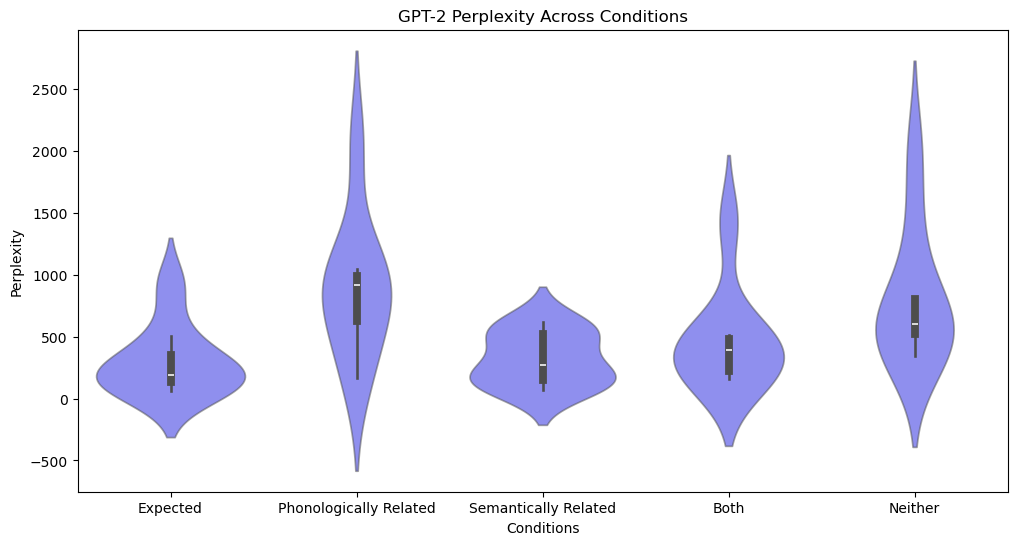

In [8]:
# Bar plot of only GPT-2 perplexity to show what we expect for a language model
plt.figure(figsize=(12, 6)) 
sns.violinplot(data=results, x = 'condition_name', y = 'gpt2_perplexity', color="blue", alpha=0.5)

plt.xlabel("Conditions")
plt.ylabel("Perplexity")
plt.title("GPT-2 Perplexity Across Conditions")
    
plt.show()

In the violin plot above depicting GPT-2 perplexity across conditions, the `Expected` and `Semantically Related` conditions show the lowest average perplexity, indicating that the model considers these completions highly predictable. Average perplexity increases for the `Both` (phonologically- and semantically-related) condition, followed by the `Neither` condition. Finally, the `Phonologically Related` condition results in the highest average perplexity, implying that the model is highly uncertain of these sentence completions. Overall, this a predictable pattern from a pure language model because semantically-related, plausible completions are statistically more predictable than impluasible completions. Furthermore, GPT-2 is not inherently trained to recognize phonological patterns, so phonological relatedness should not have an effect on perplexity. However, the results suggest that there could potentially be some sort of inhibitory effect associated with phonological relatedness that results in higher perplexity.

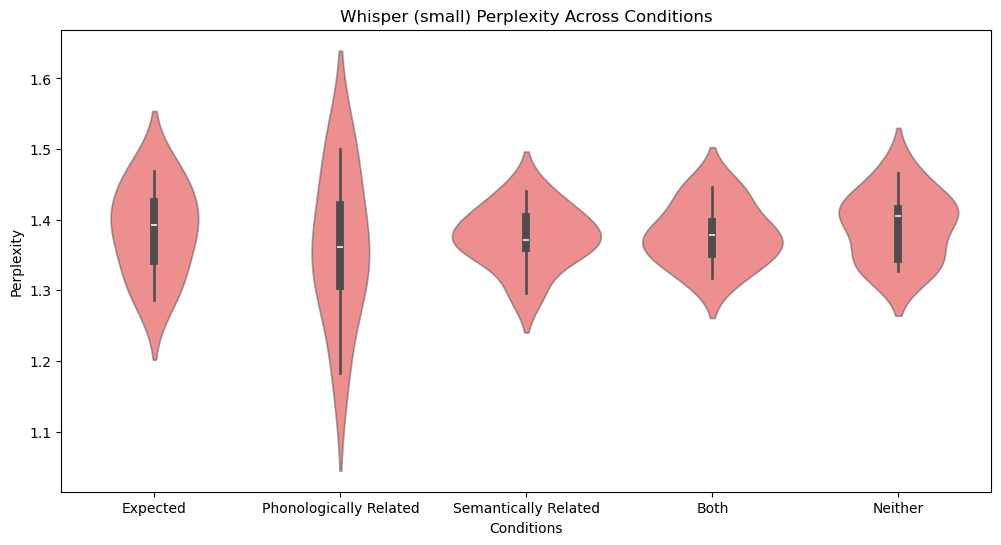

In [12]:
# Bar plot showing Whisper perplexity
plt.figure(figsize=(12, 6)) 
sns.violinplot(data=results, x = 'condition_name', y = 'whisper_perplexity', color="red", alpha=0.5)

plt.xlabel("Conditions")
plt.ylabel("Perplexity")
plt.title("Whisper (small) Perplexity Across Conditions")
    
plt.show()

The box plot above shows that average perplexity from the Whisper model is relatively stable across all experimental conditions, assigning similar perplexity to all sentences. The range of perplexity scores are also much lower overall and exhibit less variability compared to GPT-2 perplexity. This suggests that both semantic predictability and phonological-relatedness do not have an effect on Whisper's predictions. In particular, Whisper does not seem to be strongly biased towards predictable (semantically-related) completions like GPT-2. Phonological relatedness does seem to demonstrate higher variability than the other conditions, but the scale of this variability is very small (less than 1 unit).

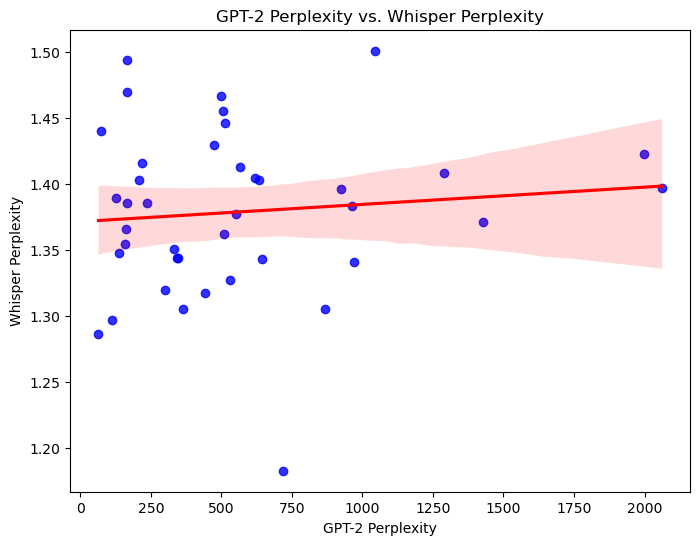

In [11]:
# Depict correlation between Whisper and GPT-2 perplexity
plt.figure(figsize=(8, 6))
sns.regplot(x=results["gpt2_perplexity"], y=results["whisper_perplexity"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("GPT-2 Perplexity")
plt.ylabel("Whisper Perplexity")
plt.title("GPT-2 Perplexity vs. Whisper Perplexity")
plt.show()

In [12]:
# Compute correlation between GPT-2 and Whisper perplexity
correlation = results["gpt2_perplexity"].corr(results["whisper_perplexity"])
print(f"Pearson correlation between GPT-2 and Whisper perplexity: {correlation:.4f}")

Pearson correlation between GPT-2 and Whisper perplexity: 0.1001


The above scatterplot depicting the relationship between Whisper and GPT-2 perplexity reinforces the idea that Whisper behaves differently than a pure language model. The plot does not show a clear or strong correlation between Whisper perplexity and GPT-2 perplexity, as evidenced by the widely-dispersed points and low reported Pearson correlation coefficient ($r=0.1001$). The wide confidence interval also implies that there is a lot of uncertainty in this relationship, especially at higher GPT-2 perplexity scores.

## Discussion

This study aims to examine whether Whisper (small) biases its language model component over its ASR component when transcribing speech input. To do so, I compare perplexity between Whisper and GPT-2 across five experimental conditions, manipulating semantic- and phonological-relatedness of sentence completions. 

GPT-2 shows a systematic negative effect of semantic relatedness on perplexity. This pattern is expected from a pure language model. The `Expected`, `Semantically Related`, and `Both` conditions involve completions that are both predictable and plausible based on the preceding context, resulting in lower average perplexity. On the other hand, the `Neither` and `Phonologically Related` sentence completions are not predictable based on context and therefore result in higher average perplexity. 

I would have expected that the `Neither` condition results in the highest perplexity, however a potential reason for this outcome may be attributed to tokenization. [Chai et al. (2024)](https://arxiv.org/abs/2406.11687) explains that tokenization remains a complex issue, and explores how even state-of-the-art language models continue to suffer from drawbacks associated with these methods. To illustrate a simple example of how tokenization could potentially affect perplexity, I use the word "couch" from the first stimuli set as a dummy example. It is possible that the GPT-2 tokenizer represents the word as two independent, statistically rare tokens, "cou" and "ch", which would explain why the overall sentence would be assigned higher perplexity.

Whisper, on the other hand, shows low perplexity for all sentences, regardless of experimental condition. Critically, it does not seem to exhibit any effects of either semantic- or phonological-relatedness. These results ultimately support the notion that Whisper is indeed fundamentally different from a pure language model like GPT-2. It seems to prioritize the acoustic information from the speech input than linguistic probabilities to generate its transcriptions, as evidenced by the stable perplexity despite different sentence completions. Taken altogether, it is much more likely that the Whisper model exhibits some bias towards its ASR component, as opposed to its language model component. 

### Further research

There are number of ways this study could be improved. First, effects of condition could be more robustly demonstrated with more stimuli. The current analysis only examines 8 sets, which may not be a significant $n$ for capturing true effects. Additionally, it would be useful to use sentences in which semantic and phonological relatedness is quanitified and controlled. For instance, semantic relatedness could be measured using Cloze probabilities. Sentences belonging to the `Phonologically Related` and `Neither` conditions could be chosen if they do not exceed some predetermined Cloze threshold.

It would also be worthwhile to explore whether the same effects (or lack thereof) manifest on Whisper models of different sizes. Smaller models by definition have less parameters and ultimately result in lower transcription accuracy than larger models. For this reason, it may be possible that smaller models rely more heavily on their language model component to supplement or enhance transcriptions when the ASR component comes short. This task, however, is much more computationally- and time-intensive.

## Conclusion

Overall, the current analysis suggests that during transcription of sentences where semantic and phonological relatedness are manipulated, the Whisper (small) ASR model does not show any bias towards its language model over its ASR component. In fact, the lack of effect of any condition on perplexity implies that acoustic processing of the speech input takes precedence over statistical liguistic probabilities when generating predictions. 

## References

Chai, Y., Fang, Y., Peng, Q., & Li, X. (2024). Tokenization Falling Short: On Subword Robustness in Large Language Models. *arXiv preprint arXiv:2406.11687*.

Meng, Y., Zong, S., Li, X., Sun, X., Zhang, T., Wu, F., & Li, J. (2021). Gnn-lm: Language modeling based on global contexts via gnn. *arXiv preprint arXiv:2110.08743*.

Radford, A., Kim, J. W., Xu, T., Brockman, G., McLeavey, C., & Sutskever, I. (2023, July). Robust speech recognition via large-scale weak supervision. In *International conference on machine learning* (pp. 28492-28518). PMLR.
